# Escribe una aplicación de reconocimiento de objetos (p. ej. carátulas de CD, portadas de libros, cuadros de pintores, etc.) con la webcam basada en el número de coincidencias de keypoints.

# Introducción
Para construir un reconocedor de objetos necesitamos:
- Obtener features2d(keypoints) de una database de objetos
- Obtener los keypoints del nuevo objeto y compararlos con nuestra database

En este caso vamos a reconocer mariposas:

Nuestras imágenes estan sacadas de
http://www.josiahwang.com/dataset/leedsbutterfly/
`leedsbutterfly_dataset_v1.0.zip`
y son alrededor de 200 imagenes de las cuales usamos 160 para "entrenar" y 40 para test.

# Aclaración
Basandonos en que las mariposas tienen formas parecidas en las alas he podido crear un
clasificador de familias de mariposas.

# Explicación
Explicar el código en un documento jupyter es algo dificil al menos cuando se usan clases,
así pues explicare algunas funciones con mardown y el resto copiare y pegare el codigo con su 
documentacion.

## ¿ Cómo se divide el código ?

El codigo principal esta en `SIFT.py` aquí se encuentra el main y la clase `Sift` la 
cual realiza todo el trabajo.

Antes de inicializar la clase tenemos que inicializar el generador de
features2d(keypoints) 

In [1]:
# Modules needed and functions
import numpy             as np
import cv2               as cv
import matplotlib.pyplot as plt
import glob
import pickle
import glob
import pickle
import threading
# Tecnicamente append y popleft son operaciones atomicas y len() tambien
from collections import deque
from typing import List, Tuple, Deque



%matplotlib inline

def fig(w,h):
    plt.figure(figsize=(w,h))

def readrgb(file):
    return cv.cvtColor( cv.imread("../img/SIFT/"+file), cv.COLOR_BGR2RGB) 

In [2]:
# Hacemos una statica para reducir "trabajo"
def mkAKAZE(minscale=0,DEBUG=False):
    # sift = cv.xfeatures2d.SIFT_create(**defautl_sift_config)
    akaze = cv.AKAZE_create()

    def fun(x):
        kp, desc = akaze.detectAndCompute(x, mask=None)
        if DEBUG:
                flag = cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
                cv.drawKeypoints(x, kp, x, color=(100, 150, 255), flags=flag)
                fig(15,10)
                plt.imshow(x);              
        sc = np.array([k.size for k in kp])
        return desc[sc > minscale].astype(np.uint8)

    return fun

mkAkaze = mkAKAZE(DEBUG=True)

Si cargamos una imagen de ejemplo

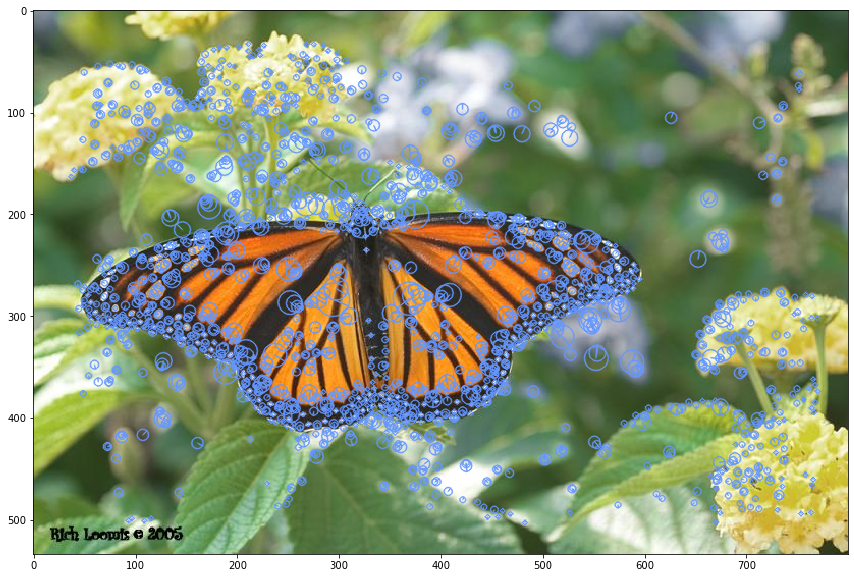

In [3]:
img = readrgb("0010015.png")
points = mkAkaze(img)

Como se puede ver las flores del fondo dan keypoints estos son los cupables de algunas clasificaciones
erróneas

Ahora calculamos todos los keypoints de la coleccíon.

In [4]:
from typing import List, Tuple, Deque

def read_files(path) -> List[Tuple[str, np.ndarray]]:
    return [(file_name, cv.imread(file_name))
            for file_name in sorted(glob.glob(path))]


def read_files_select_p(path) -> List[Tuple[str, np.ndarray]]:
    """
    Lee las imagenes y guarda un 20% en imgToTest
    Args:
        path:

    Returns:

    """
    files = read_files(path)
    indices = np.random.permutation(len(files))
    p_division = int(len(indices) * 0.8)
    training_idx, test_idx = indices[:p_division], indices[p_division:]
    training = [files[i] for i in training_idx]
    test = [files[i] for i in test_idx]
    for file_name, img in test:
        true_filename = file_name.split("\\")[1]
        # print(f"Saving {true_filename}")
        cv.imwrite(f"../img/SIFT/imgToTests/{true_filename}", img)
    return training

Usamos threads para agilizar la carga de imágenes

In [5]:
printLock = threading.Lock()
def safe_print(text):
    with printLock:
        print(text)

# Para evitar el mostrar los keypoints
# Thread calcula mkAkaze
mkAkaze = mkAKAZE(DEBUG=False)
def thread_load_sift(imgs: Deque, allpoints: Deque):
    # file, cv.imread(file)
    # pop y append son thread safe
    while imgs:
        file_name, img = imgs.popleft()
        try:
            desc = mkAkaze(img)
            # No me fio de append una tupla en la misma linea
            tp: Tuple[str, np.ndarray] = (file_name, desc)
            allpoints.append(tp)
            safe_print(f"Img:{file_name} desc:{len(desc)}")
        except TypeError:
            # No keypoints
            safe_print(f"Img:{file_name} no tiene desc :(")
            pass

In [6]:
if False:
    print("Cargando imagenes desde ficheros")
    imgs: List[Tuple[str, np.ndarray]] = read_files_select_p("../img/SIFT/images/*.png")
    deque_imgs = deque(imgs)
    allpoints = deque()
    threads = []
    for _ in range(0, 5):
        t = threading.Thread(target=thread_load_sift, args=(deque_imgs, allpoints))
        threads.append(t)
        t.start()
    # Esperamos los que los threads terminen
    [t.join() for t in threads]
    # Lo convertimos en una lista
    allpoints = list(allpoints)

    pickle.dump( allpoints, open( "../data/SIFT/allpoints.p", "wb" ) )
else:
    allpoints = pickle.load( open( "../data/SIFT/allpoints.p", "rb" ) )

Intente usar K-means matching pero tardava eones en calcular los centroides y luego al calcular el 
centroide mas cercanos siempre me salia un array a 0 y dado que el matching normal es lo suficiente
rapido.

Dado que nunca he usado clases abastractas en pyhton probe a usarlas aqui

In [9]:
from abc import ABC, abstractmethod
import numpy as np


class Matcher(ABC):
    @abstractmethod
    def find(self, x: np.ndarray):
        pass


class DefaultMatching(Matcher):
    def __init__(self, keypoints_extractor, all_points):
        self.all_points = all_points
        self.get_desc = keypoints_extractor
        self.bf = cv.BFMatcher()
        print("Matcher creado perfectamente")

    def find(self, x):
        v = self.get_desc(x)
        # [::-1] - > Reverse
        dists = sorted([(self.getcode(v, desc), file_name) for file_name, desc in self.all_points])[::-1]
        return dists

    def getcode(self, query, model):
        matches = self.bf.knnMatch(query, model, k=2)
        # ratio imgToTests
        good = []
        for m in matches:
            if len(m) == 2:
                best, second = m
                if best.distance < 0.75 * second.distance:
                    good.append(best)
        return len(good)
# Creamos un matcher
macher = DefaultMatching(mkAkaze,allpoints)

Matcher creado perfectamente


Una vez que hemos creado el matcher solo tenemos que capturar una imagen y probarlo.
Si usamos una imagen de prueba el programa nos dara la imagen mas parecida y en este caso acepta la clasificacion.

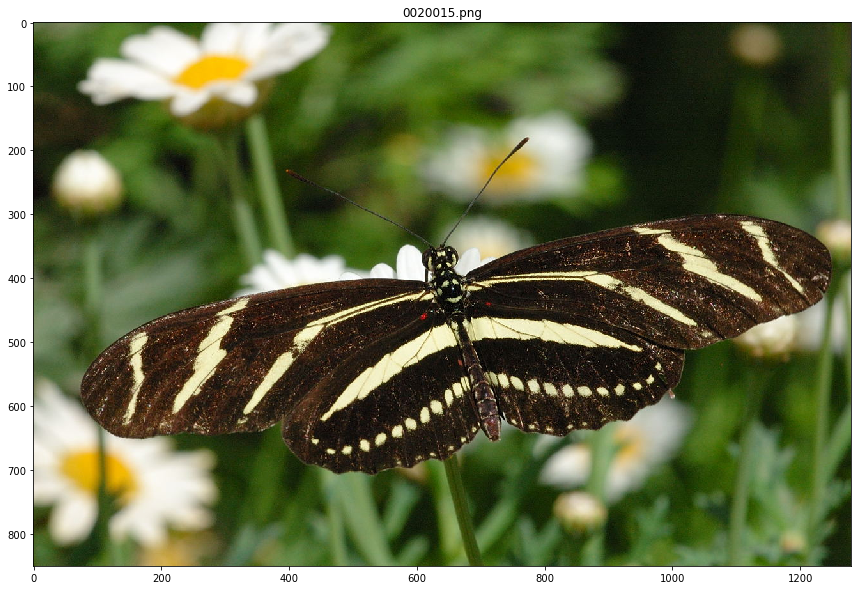

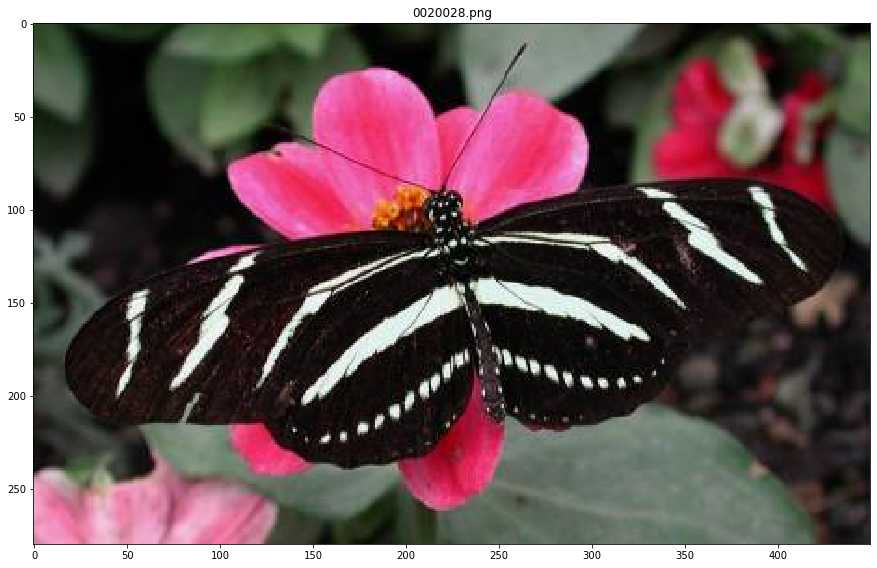

In [30]:
def show_img_bgr(x,tittle):
    fig(15,10)
    plt.imshow(cv.cvtColor(x,cv.COLOR_BGR2RGB)); plt.title(tittle)

# Cargamos la imagen
img = cv.imread("../img/SIFT/imgToTests/0020015.png")
show_img_bgr(img,"Entrada")
values: List[Tuple[int, str]] = macher.find(img)
#print(values)
puntos_comun, path_foto = values[0]
# Imagen co
img = cv.imread(path_foto)
show_img_bgr(img,"Imagen mas parecida")

Obviamente si metemos alguna imagen que ya este en allpoints nos mostrara la misma


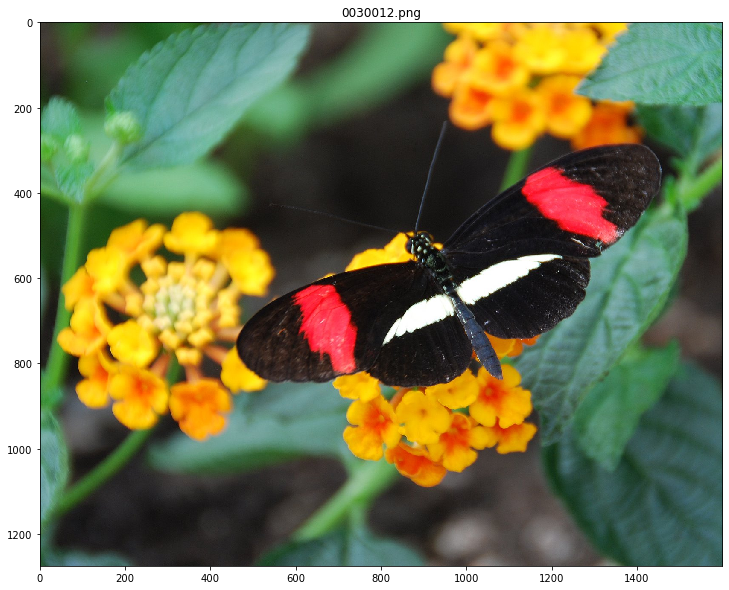

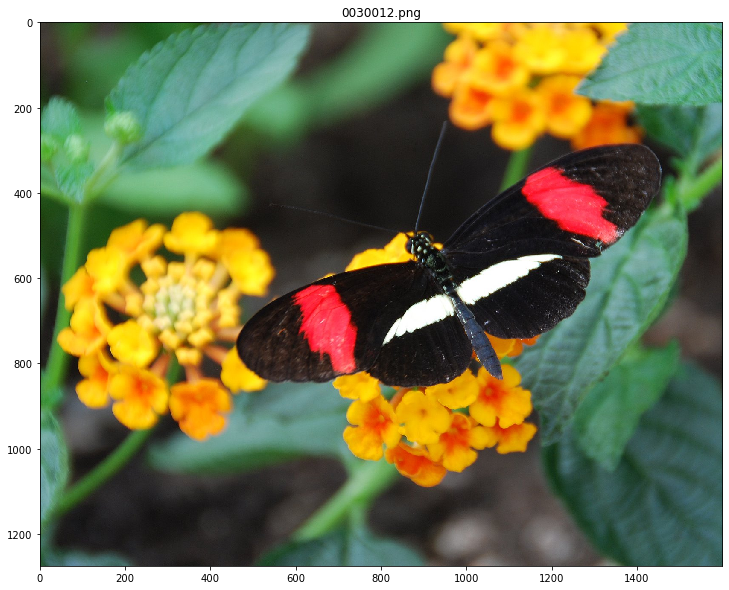

In [32]:
# Cargamos la imagen
img = cv.imread("../img/SIFT/images/0030012.png")
show_img_bgr(img,"0030012.png")
values: List[Tuple[int, str]] = macher.find(img)
#print(values)
puntos_comun, path_foto = values[0]
true_filename = path_foto.split("\\")[1]
# Imagen con mas puntos en comun
img = cv.imread(path_foto)
show_img_bgr(img,true_filename)

Si modificamos las imagenes tambien puede calcular la familia


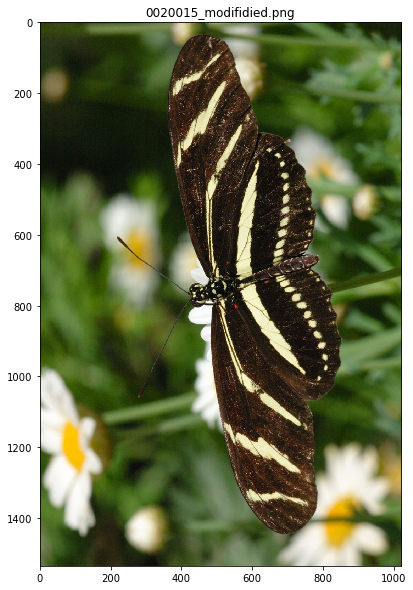

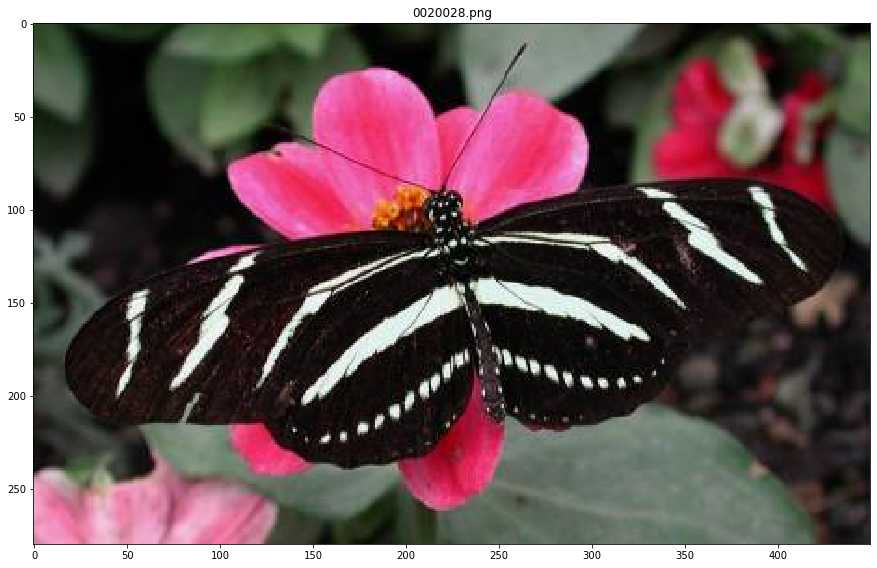

In [33]:
img = cv.imread("../img/SIFT/imgToTests/0020015.png")
obs  = np.rot90(cv.GaussianBlur(cv.resize(img,(0,0), fx=1.2, fy=1.2),(0,0), 0.1),1)
show_img_bgr(obs,"0020015_modifidied.png")
values: List[Tuple[int, str]] = macher.find(img)
puntos_comun, path_foto = values[0]
true_filename = path_foto.split("\\")[1]
# Imagen con mas puntos en comun
img = cv.imread(path_foto)
show_img_bgr(img,true_filename)

Y ahora calculamos que grupo de mariposas tiene mas keypoints en comun con la imagen
actual.
Para esto obetenemos la suma de los keypoints para cada familia de mariposas y selecionamos la que tiene mas en común

In [34]:
butteflies = {
    1: "Danaus plexippus",
    2: "Heliconius charitonius",
    3: "Heliconius erato",
    4: "Junonia coenia",
    5: "Lycaena phlaeas",
    6: "Nymphalis antiopa",
    7: "Papilio cresphontes",
    8: "Pieris rapae",
    9: "Vanessa atalanta",
    0: "Vanessa cardui"
}
def get_id(name_img):
    true_filename = name_img.split("\\")[1]
    id_butterfly = int(true_filename[2])
    return id_butterfly

# Cargamos la imagen
img = cv.imread("../img/SIFT/imgToTests/0020015.png")
values: List[Tuple[int, str]] = macher.find(img)
puntos_comun, path_foto = values[0]
img = cv.imread(path_foto)

lista_puntos_comun = [0] * 10

for puntos_comun, path_foto in values:
    # Añadimos un threshold
    if puntos_comun >= 5:
        id_butterfly = get_id(path_foto)
        lista_puntos_comun[id_butterfly] += puntos_comun

#print(lista_puntos_comun)
# Obtenemos el indice del mas parecido
indice_mas_parecido: int = int(np.argsort(lista_puntos_comun)[-1])
nombre_mariposa = butteflies[indice_mas_parecido]
print(f"La mariposa deberia de ser {nombre_mariposa}")

[132, 112, 449, 289, 174, 121, 187, 192, 129, 177]
La mariposa deberia de ser Heliconius charitonius
